In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
import matplotlib.pyplot as plt
from tensorflow import keras


In [2]:
#Constant values
image_size_ = 256
batch_size_ = 32
channels_ = 3
EPOCHS = 40

In [3]:
garbage_ds = tf.keras.preprocessing.image_dataset_from_directory("BINS",
                                                    shuffle = True,
                                                    image_size = (image_size_,image_size_),
                                                    batch_size = batch_size_
                                                   )

Found 5235 files belonging to 5 classes.


In [4]:
class_names = garbage_ds.class_names
class_names


['BLACK', 'BLUE_BAG', 'BLUE_BIN', 'GARDEN', 'GREEN']

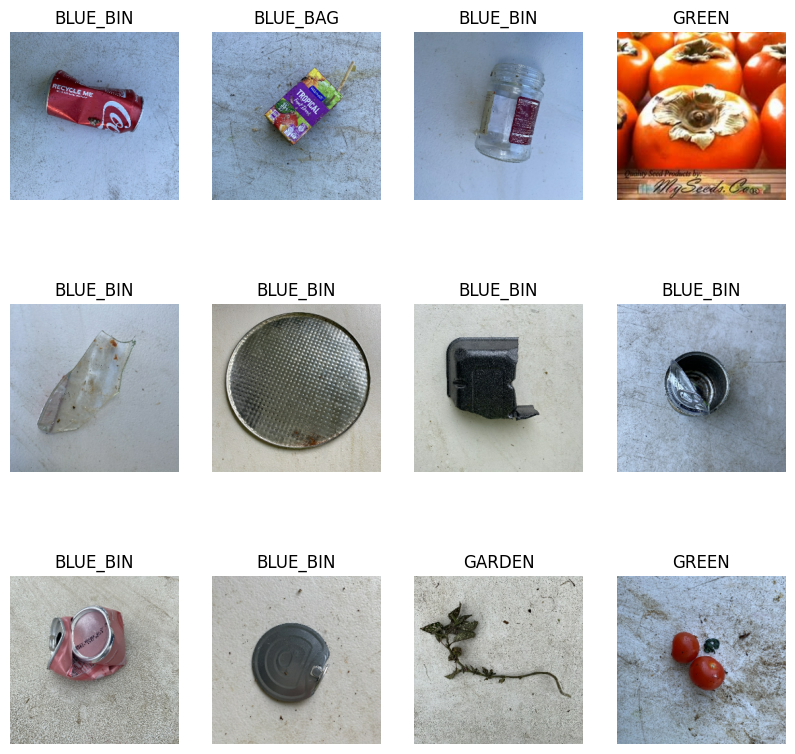

In [5]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in garbage_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,+i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])  
        plt.axis("off")

In [6]:
def get_splited_data(ds, train_split = 0.8, validation_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    assert (train_split + validation_split + test_split) == 1,"Splits must add up to 1."
    
    ds_size = len(ds)
    if shuffle:
        ds= ds.shuffle(shuffle_size, seed = 12)
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * validation_split)
    test_size = int(ds_size * test_split)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size).take(test_size)

    return train_ds, val_ds, test_ds



In [7]:
train_ds, val_ds, test_ds = get_splited_data(garbage_ds)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size_, image_size_),
    layers.Rescaling(1.0 / 255)
])

In [9]:
data_augmentation =  tf.keras.Sequential([
    # Flip horizontally and vertically
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    # Rotate images by up to ±20%
    tf.keras.layers.RandomRotation(0.2),
    # Randomly zoom into the image
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
])


In [10]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
from tensorflow.keras import layers, models, regularizers

# Define the input shape and number of classes
input_shape = (batch_size_, image_size_, image_size_, channels_)
n_classes = 5

# Define the model
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(96, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(96, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(n_classes, activation='softmax'),
])

# Build the model
model.build(input_shape=input_shape)


C:\Users\juan_\anaconda3\envs\Projects\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    verbose=1, 
    restore_best_weights=True
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce learning rate by half
    patience=3,  # After 3 epochs without improvement
    min_lr=1e-6
)

history = model.fit(
    train_ds,
    batch_size=batch_size_,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
    callbacks=[lr_scheduler]
)

Epoch 1/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.4537 - loss: 1.5706 - val_accuracy: 0.5215 - val_loss: 1.3017 - learning_rate: 0.0010
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.5166 - loss: 1.2532 - val_accuracy: 0.6055 - val_loss: 1.1050 - learning_rate: 0.0010
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 108s 822ms/step - accuracy: 0.5534 - loss: 1.1136 - val_accuracy: 0.6191 - val_loss: 1.0133 - learning_rate: 0.0010
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 104s 793ms/step - accuracy: 0.5996 - loss: 1.0305 - val_accuracy: 0.6367 - val_loss: 0.8962 - learning_rate: 0.0010
Epoch 5/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 106s 806ms/step - accuracy: 0.6210 - loss: 0.9874 - val_accuracy: 0.5703 - val_loss: 1.0748 - learning_rate: 0.0010
Epoch 6/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 85s 647ms/step - accuracy: 0.6280 - loss: 0.9468 - val_accuracy: 0.6719 - val_loss: 0.8685 - learning_rate: 0.0010
Epoch 7/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 86s 653ms/step - accuracy: 0.63

In [13]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 96)       │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 96)       │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 128)        │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 512)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 128)              │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 5)                │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,115,345 (4.25 MB)

 Trainable params: 371,781 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 743,564 (2.84 MB)

In [14]:
scores = model.evaluate(test_ds)
scores

16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 177ms/step - accuracy: 0.7783 - loss: 0.6798


[0.6946868896484375, 0.771484375]

In [15]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 131}

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

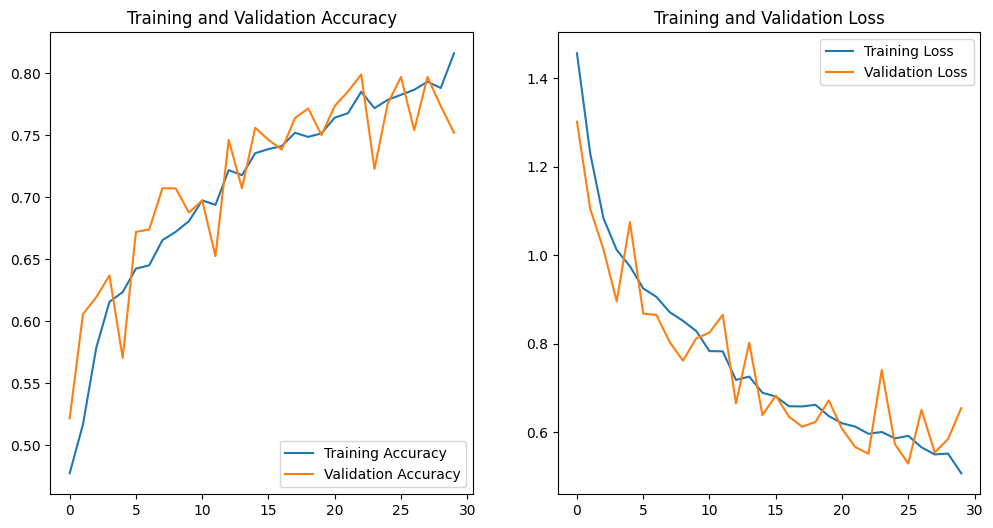

In [17]:
epochs = len(acc)

plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [18]:
scores_test= model.evaluate(test_ds)
scores_test

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.7466 - loss: 0.7237


[0.6946868896484375, 0.771484375]

In [19]:
scores_val = model.evaluate(val_ds)
scores_val

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.7450 - loss: 0.7036


[0.6550179719924927, 0.751953125]

In [20]:
scores_train = model.evaluate(train_ds)
scores_train

131/131 ━━━━━━━━━━━━━━━━━━━━ 61s 465ms/step - accuracy: 0.8157 - loss: 0.5196


[0.51900315284729, 0.8147882223129272]

First image to predict
First image's actual label: BLACK
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
Predicted label: GREEN


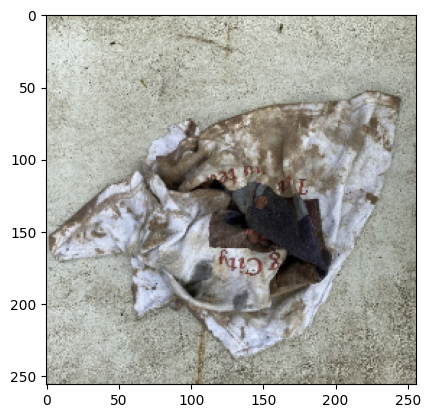

In [21]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]
    
    print("First image to predict")
    plt.imshow(first_image)
    print("First image's actual label:",class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])

In [22]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch

    predictions = model.predict(img_array)

    predicted_label = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_label, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


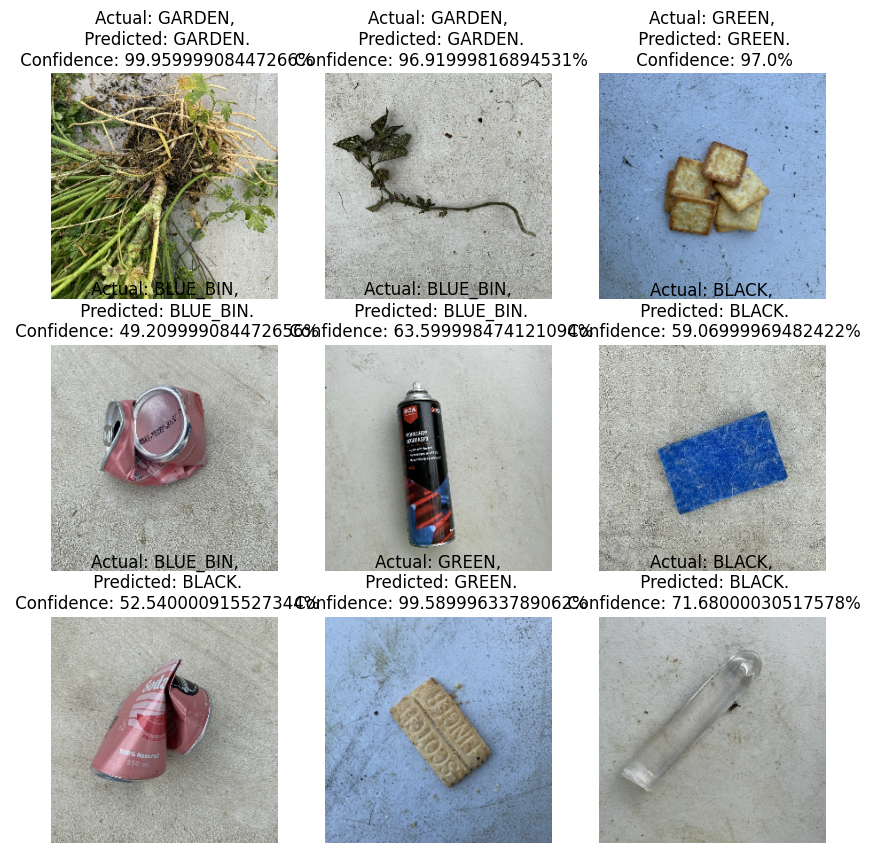

In [23]:
plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [24]:
model_version = "Waste_classifier_V2"
model.save(f"../models/{model_version}.keras")